In [1]:
#Importing the necessary libraries for the script
import geemap
import ee
from pathlib import Path
import geopandas as gpd
from functions import *

In [2]:
#Authenticating the Google Earth Engine API
ee.Authenticate()
ee.Initialize()
geemap.ee_initialize()

In [9]:
#Setting the Out Directory if not exists creating it
out_dir = Path('../Data')
out_dir.mkdir(exist_ok=True)

#Shapefile directory of the area of interest
shp_dir = Path('../Shapefile/BegnasArea.shp')
studyarea = get_eesupported_roi(shp_dir)

In [5]:
#define a time frame
start_time = '2021-12-01'
end_time = '2022-11-30'

In [10]:
#Landsat 8 and 9 Image collection
landsat8_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate(start_time, end_time).filterBounds(studyarea).filter(ee.Filter.lt('CLOUD_COVER', 10))
landsat9_collection = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2').filterDate(start_time, end_time).filterBounds(studyarea).filter(ee.Filter.lt('CLOUD_COVER', 10))

In [23]:
#Function to calculate the LST
def calculate_lst(image):
    radiance = image.select('ST_B10').multiply(0.0003342).add(0.1)
    
    #Convert Radiance to brightness temperature
    k1_constant = ee.Number(774.8853)
    k2_constant = ee.Number(1321.0789)
    
    bt = radiance.expression(
            'K2 / log((K1 / L) + 1)', {
            'K1': k1_constant,
            'K2': k2_constant,
            'L': radiance
        }
    )
    
    # Estimate Land Surface Emissivity (LSE)
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4'])
    pv = ndvi.expression('((NDVI - 0.2) / 0.3) ** 2', {'NDVI': ndvi})
    lse = pv.multiply(0.004).add(0.986).rename('LSE')
    
    # Calculate LST in Kelvin
    lst = bt.expression(
        'BT / (1 + (0.00115 * BT / 1.4388) * log(LSE))', {
            'BT': bt,
            'LSE': lse
        }
    ).subtract(273.15).rename('LST')  # Convert to Celsius
    
    return image.addBands(lst)

In [28]:
# Map the LST calculation over the collection
lst_collection = landsat9_collection.map(calculate_lst)

def extract_mean_lst(image):
    mean_lst = image.select('LST').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=studyarea,
        scale=30,
        maxPixels=1e9
    )
    return ee.Feature(None, {'date': image.date().format('YYYY-MM-dd'), 'LST': mean_lst.get('LST')})


In [29]:
# Apply the function over the collection
lst_time_series = lst_collection.map(extract_mean_lst).filter(ee.Filter.notNull(['LST']))


In [30]:
# Convert to a Pandas DataFrame
lst_dict = lst_time_series.getInfo()['features']
dates = [feature['properties']['date'] for feature in lst_dict]
lst_values = [feature['properties']['LST'] for feature in lst_dict]

df = pd.DataFrame({
    'Date': pd.to_datetime(dates),
    'LST (°C)': lst_values
})

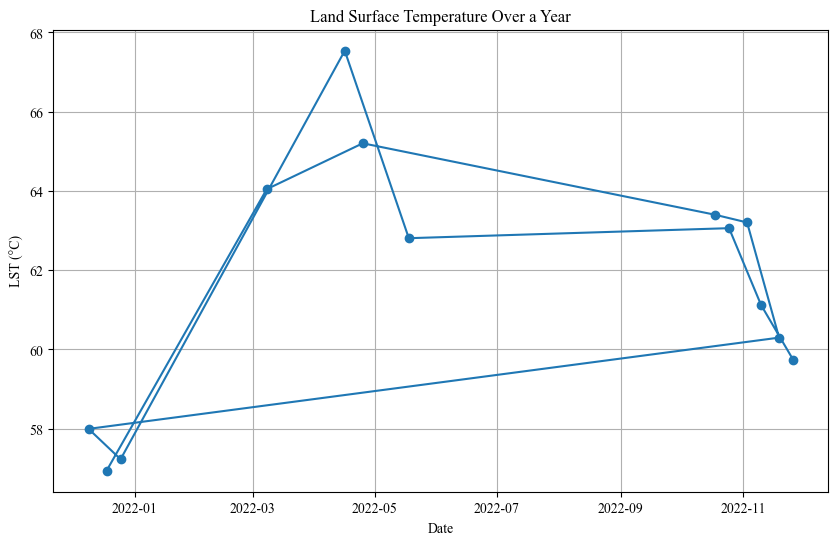

In [31]:
# Plot the LST time series
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['LST (°C)'], marker='o')
plt.title('Land Surface Temperature Over a Year')
plt.xlabel('Date')
plt.ylabel('LST (°C)')
plt.grid(True)
plt.show()

In [39]:
# Function to calculate the LST
def calculate_lst(image):
    # Calculate Top of Atmosphere (TOA) radiance
    radiance = image.select('ST_B10').multiply(0.0003342).add(0.1)
    
    # Convert radiance to brightness temperature in Kelvin
    k1_constant = 774.8853
    k2_constant = 1321.0789
    
    bt = ee.Image(k2_constant).divide(radiance.log().add(ee.Image(k1_constant).divide(radiance)))
    
    # Estimate Land Surface Emissivity (LSE)
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4'])
    pv = ndvi.expression('((NDVI - 0.2) / 0.3) ** 2', {'NDVI': ndvi})
    lse = pv.multiply(0.004).add(0.986)
    
    # Correct brightness temperature for LSE and convert to Celsius
    lst = bt.divide(lse).subtract(273.15).rename('LST')  # Convert to Celsius
    
    return image.addBands(lst)

# Map the LST calculation over the Landsat 8 collection
lst_collection = landsat8_collection.map(calculate_lst)

# Function to calculate mean LST for a month
def calculate_monthly_mean(year, month):
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')
    
    monthly_collection = lst_collection.filterDate(start_date, end_date)
    
    mean_lst = monthly_collection.select('LST').mean().reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=studyarea,
        scale=30,
        maxPixels=1e9
    )
    
    # Ensure 'mean_LST' is extracted correctly
    return ee.Feature(None, {
        'month': start_date.format('YYYY-MM'),
        'mean_LST': mean_lst.get('LST')
    })

# Create a list of months in the year
months = ee.List.sequence(1, 12)

# Calculate mean LST for each month
monthly_lst_features = months.map(lambda m: calculate_monthly_mean(2022, m))
monthly_lst_collection = ee.FeatureCollection(monthly_lst_features)

# Convert to a Pandas DataFrame
lst_dict = monthly_lst_collection.getInfo()['features']
months = [feature['properties']['month'] for feature in lst_dict]
lst_values = [feature['properties']['mean_LST'] for feature in lst_dict]

df = pd.DataFrame({
    'Month': pd.to_datetime(months),
    'Mean LST (°C)': lst_values
})

# Sort DataFrame by month
df = df.sort_values('Month')

# Plot the monthly mean LST time series
plt.figure(figsize=(10, 6))
plt.plot(df['Month'], df['Mean LST (°C)'], marker='o')
plt.title('Monthly Mean Land Surface Temperature (Landsat 8)')
plt.xlabel('Month')
plt.ylabel('Mean LST (°C)')
plt.grid(True)
plt.show()

EEException: Dictionary.get: Dictionary does not contain key: 'LST'.